In [1]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
import warnings
import numpy as np
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import japanize_matplotlib

In [2]:
df = pd.read_csv('ml_before.csv')

In [3]:
# 説明変数と不要な列を落とす
X = df.drop(['日付け', '終値'], axis=1)
y = df['終値']

特徴選択

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

# 特徴選択器の作成
rfr = RandomForestRegressor(random_state=42)
rfe = RFE(estimator=rfr, n_features_to_select=5)

# # 元の特徴量だけで特徴選択の実行と選択された特徴量のデータフレームの作成
rfe.fit(X, y)
X_rfe = X.loc[:, rfe.support_]

# 選択された特徴量の数の確認
print("選択された特徴量の数: {}".format(X_rfe.shape[1]))

X_rfe.head()

選択された特徴量の数: 5


,始値,高値,安値,変化率 %,today_price
0,159.3,159.4,156.1,-2.56,3.0
1,158.2,160.7,158.1,1.07,-2.2
2,158.8,159.2,158.0,-0.63,0.1
3,158.7,160.2,158.4,1.14,-1.0
4,159.3,159.6,157.9,-0.13,1.4


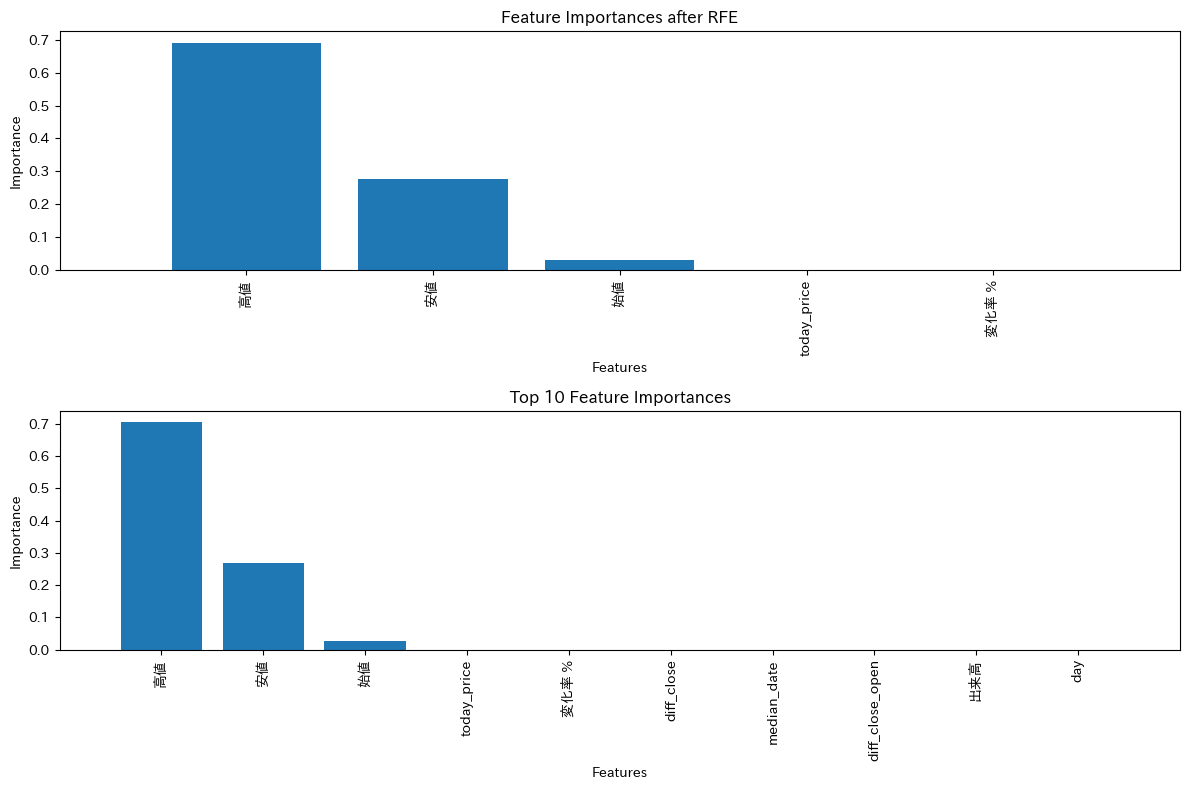

In [5]:
# 選択された特徴量の重要度を取得
selected_importances = rfe.estimator_.feature_importances_

# 選択された特徴量名を取得
selected_features = X_rfe.columns

# すべての特徴量の重要度を取得
all_importances = RandomForestRegressor(random_state=42).fit(X, y).feature_importances_

# すべての特徴量の名前を取得
all_features = X.columns

# 選択された特徴量の重要度と特徴量名を並べ替え
sorted_indices = np.argsort(selected_importances)[::-1]
sorted_selected_importances = selected_importances[sorted_indices]
sorted_selected_features = selected_features[sorted_indices]

# 特徴量重要度の比較プロット
plt.figure(figsize=(12, 8))

# 選択された特徴量の重要度のプロット
plt.subplot(2, 1, 1)
plt.title("Feature Importances after RFE")
plt.bar(range(len(sorted_selected_importances)), sorted_selected_importances, align="center")
plt.xticks(range(len(sorted_selected_importances)), sorted_selected_features, rotation=90)
plt.xlim([-1, len(sorted_selected_importances)])
plt.xlabel('Features')
plt.ylabel('Importance')

# すべての特徴量の重要度のプロット（上位10個）
indices = np.argsort(all_importances)[::-1][:10]
plt.subplot(2, 1, 2)
plt.title("Top 10 Feature Importances")
plt.bar(range(len(indices)), all_importances[indices], align="center")
plt.xticks(range(len(indices)), np.array(all_features)[indices], rotation=90)
plt.xlim([-1, len(indices)])
plt.xlabel('Features')
plt.ylabel('Importance')

plt.tight_layout()
plt.show()

モデルの学習・テストに使用するデータの準備

In [7]:
df['日付け'] = pd.to_datetime(df['日付け'])
# 週の特徴量の追加
df['week'] = df['日付け'].dt.isocalendar().week
df['week_cos'] = df['week'].apply(lambda x: np.cos(2 * np.pi * x / 52))
df['week_sin'] = df['week'].apply(lambda x: np.sin(2 * np.pi * x / 52))

# 月の特徴量の追加
df['month'] = df['日付け'].dt.month
df['month_cos'] = df['month'].apply(lambda x: np.cos(2 * np.pi * x / 12))
df['month_sin'] = df['month'].apply(lambda x: np.sin(2 * np.pi * x / 12))

# 四半期の特徴量の追加
df['quarter'] = df['日付け'].dt.quarter
df['quarter_cos'] = df['quarter'].apply(lambda x: np.cos(2 * np.pi * x / 4))
df['quarter_sin'] = df['quarter'].apply(lambda x: np.sin(2 * np.pi * x / 4))

# 日の特徴量の追加
df['day'] = df['日付け'].dt.day
df['day_cos'] = df['day'].apply(lambda x: np.cos(2 * np.pi * x / 31))
df['day_sin'] = df['day'].apply(lambda x: np.sin(2 * np.pi * x / 31))

In [8]:
X_rfe['終値'] = df['終値']

X_rfe['week_cos'] = df['week_cos']
X_rfe['week_sin'] = df['week_sin']

X_rfe['month_cos'] = df['month_cos']
X_rfe['month_sin'] = df['month_sin']

X_rfe['quarter_cos'] = df['quarter_cos']
X_rfe['quarter_sin'] = df['quarter_sin']

X_rfe['day_cos'] = df['day_cos']
X_rfe['day_sin'] = df['day_sin']

In [9]:
column_to_move = '終値'

cols = [column_to_move] + [col for col in X_rfe.columns if col != column_to_move]
X_rfe = X_rfe[cols]

In [10]:
X_rfe.head()

,終値,始値,高値,安値,変化率 %,today_price,week_cos,week_sin,month_cos,month_sin,quarter_cos,quarter_sin,day_cos,day_sin
0,156.3,159.3,159.4,156.1,-2.56,3.0,-0.822984,-0.568065,-0.500000,-0.866025,-1.836970e-16,-1.0,0.979530,2.012985e-01
1,160.4,158.2,160.7,158.1,1.07,-2.2,-0.822984,-0.568065,-0.866025,-0.500000,-1.836970e-16,-1.0,1.000000,-2.449294e-16
2,158.7,158.8,159.2,158.0,-0.63,0.1,-0.822984,-0.568065,-0.866025,-0.500000,-1.836970e-16,-1.0,0.979530,-2.012985e-01
3,159.7,158.7,160.2,158.4,1.14,-1.0,-0.822984,-0.568065,-0.866025,-0.500000,-1.836970e-16,-1.0,0.918958,-3.943559e-01
4,157.9,159.3,159.6,157.9,-0.13,1.4,-0.885456,-0.464723,-0.866025,-0.500000,-1.836970e-16,-1.0,0.528964,-8.486443e-01


In [11]:
X_rfe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9202 entries, 0 to 9201
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   終値           9202 non-null   float64
 1   始値           9202 non-null   float64
 2   高値           9202 non-null   float64
 3   安値           9202 non-null   float64
 4   変化率 %        9202 non-null   float64
 5   today_price  9202 non-null   float64
 6   week_cos     9202 non-null   float64
 7   week_sin     9202 non-null   float64
 8   month_cos    9202 non-null   float64
 9   month_sin    9202 non-null   float64
 10  quarter_cos  9202 non-null   float64
 11  quarter_sin  9202 non-null   float64
 12  day_cos      9202 non-null   float64
 13  day_sin      9202 non-null   float64
dtypes: float64(14)
memory usage: 1006.6 KB


In [12]:
X_rfe.to_csv('ml_after.csv', index=False)